<h1>LEARNING FROM TOP TEN MASTERCARD INDEX DESTINATION CITIES</h1>
<p>Victor Mawusi Ayi</p>

In [ ]:
import re
import requests
import numpy as np
import matplotlib.pyplot as plt
import folium
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr, spearmanr 
from geopy.geocoders import Nominatim

<h2> FUNCTIONS FOR REPETITIVE METHODS

<h4> Table grabber </h4>

In [77]:
#function to grab tables
def get_tables(url):    
    
    page = requests.get(url).text
    
    REs = (re.compile(r'<table[^>]*>.*?</table>', re.DOTALL), re.compile(r'<tr[^>]*>.*?</tr>', re.DOTALL), \
          re.compile(r'<td[^>]*>(.*?)</td>', re.DOTALL))
    
    tables = [[REs[2].findall(row) for row in table] for table in \
                   [REs[1].findall(table) for table in REs[0].findall(page)]]
    
    return(tables)
    

<h4> KMeans cluster function</h4>

Does two things:
<ul>
    <li>Returns dictionary of Ks, Sum of Squared Distances, and List of lists of labels for each K</li>
    <li>Plots K values against corresponding Sums of squared distances, to help visualise elbow</li>
</ul>

In [78]:

def kmeans_cluster(topcities_for_k, k_max):
    
    topcities_s = StandardScaler().fit(topcities_for_k).transform(topcities_for_k)
    
    ks = list(range(1, k_max))
    sumsqdis = []  #To store a list of Ks, and a list of Sum of squared distances
    k_labels = []  #To store arrays of labels for each k

    #run clustering using diffrent Ks and obtaining their Sum of squared distances
    for k in ks:
        kmeans2 = KMeans(init='k-means++', n_clusters=k).fit(topcities_s)
        sumsqdis.append(kmeans2.inertia_)
        k_labels.append(kmeans2.labels_)
    
    # Plot Ks and Sums of squared distances to visualize elbow
    plt.figure(figsize=(10,6))
    plt.plot(ks, sumsqdis)
    plt.xlabel('K values')
    plt.ylabel('Sum of squared distances')
        
    
    return {'ks':ks, 'sumsqdis':sumsqdis, 'clabels':k_labels}


<h4> Scatter Plotting with correlation statistics </h4>

In [80]:
def scatter_corr(x, y, xlab, ylab, title):
    p_r = pearsonr(x, y)
    
    print('Pearson Correlation: Coefficient = {}, p-value = {}'.format(p_r[0], p_r[1]))
    print(spearmanr(x, y))
    
    plt.figure(figsize=(8,4))
    plt.scatter(x, y)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    

<h4>Latitude and Longitude getter using Nominatim geocoder</h4>
<p>Takes an iterable of city names, and returns a dataframe containing cities, latitude and longitude</p>

In [82]:
def get_lonlats(city_list):
    geolocator = Nominatim(user_agent='MC_T_index')

    #obtaining and storing latitudes and longitudes in dictionary
    lonlats = {}

    for city in city_list:
        location = geolocator.geocode(city)
        lonlats[city] = (location.latitude, location.longitude)
    
    lonlats_df = pd.DataFrame(lonlats).transpose().reset_index()
    lonlats_df.columns=['City', 'Latitude', 'Longitude']
    
    return lonlats_df    

<h4> Query Foursquare Venue Data for List of Cities

In [83]:
# @hidden_cell

CLIENT_ID='DCIL0YEFVR5MCIAFRNQYIXZWDKR12SOC2GYQV1RQBCVUHXNG'
CLIENT_SECRET='TBUKKUNKG0HW5RJAEKWF5G4POEQTFTEVIUCBDQH53NTPLVJD'
VERSION='20190101'


def nearby_services(geo_data, LIMIT=300, RADIUS=8000, CATEGORYID='4d4b7105d754a06378d81259'):
   
    city_loc=[]
    
    for city, lat, lon, clust in zip(geo_data['City'], geo_data['Latitude'], geo_data['Longitude'], top_cities_clust['ClusterLabels']):
        
        LL='{},{}'.format(lat, lon) #latitude and longitude values of cities
        
        #print(LL)
       
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={}&radius={}&limit={}&intent=browse&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            LL, 
            RADIUS, 
            LIMIT,
            CATEGORYID)
        
        #print(url)
        
        query_data = requests.get(url).json()['response']['venues']
        
        for data in query_data:
            if data['categories']==[]:
                #Making provision for venues which didnt have categories assigned
                #will insert 'not assigned' for venues without categories
                data['categories']=[{'name':'not assigned', 'id':'not assigned'}]   
            
            city_loc.append([city, lat, lon, clust, data['name'], data['location']['lat'], \
                             data['location']['lng'], data['categories'][0]['name'], \
                             data['categories'][0]['id']])
            
        
    headers = ['City', 'CityLatitude', 'CityLongitude', 'ClusterLabels', 'VenueName', \
               'VenueLatitude', 'VenueLongitude', 'VenueCategoryName', 'VenueCategoryId']
    
    return {'venues':city_loc, 'headers':headers}

<h4>Generator for folium map with color coded markers to visualize distribution of cities across continents

In [84]:
def map_folium(dataframe, clus_dict, circle_radius = 8, loc = [-8.7832, 34.5085]):
    
    world_map = folium.Map(location = loc, zoom_start=2.35, tiles='MapBox Bright')

    colors=['red', 'green', 'cyan', 'yellow', 'blue', 'violet']

    #Mapping colors to the various clusters and their description to be used for Key for the map
    print('[ MAP KEY ]')
    mapkey = []    

    #Annotating markers
    for city, lat, lon, cluster in zip(dataframe['City'], dataframe['Latitude'], dataframe['Longitude'], dataframe['ClusterLabels']):
    
        mapkey.append('{}: {}\n'.format(colors[int(cluster)].upper(), clus_dict[cluster]['Description']))
    
        folium.CircleMarker(
            [lat, lon],
            radius=circle_radius,
            color=colors[int(cluster)],
            popup='{}, {}'.format(city.upper(), clus_dict[cluster]['Description']), 
            fill=True,
            fill_color=colors[int(cluster)],
            fill_opacity=0.9).add_to(world_map)
    
    mapkeystr = ''
    for item in set(mapkey):
        mapkeystr += item 
        
    return {'map': world_map, 'mapkey': mapkeystr}

<h2> 2. MASTERCARD TOP TEN DESTINATION CITIES 2017 DATA RETRIEVAL AND EXPLORATION

<h3>a. Data Retrieval</h3>
<p>Using the above function to pull tables from MasterCard International Destination Index 2017 announcement site. Displaying table in a list of lists. The bigger lists represent each table, and the smaller lists within them represent table rows.<p>

In [85]:
MC_tables = get_tables('https://newsroom.mastercard.com/press-releases/big-cities-big-business-bangkok-london-and-paris-lead-the-way-in-mastercards-2018-global-destination-cities-index/')

MC_tables

[[['<strong>The Global Top 10 Destination Cities</strong>'],
  ['',
   '2017 International Overnight Visitors',
   'Growth Forecast for 2018',
   'Average Length of Stay',
   'Average Spend Per Day'],
  ['Bangkok', '20.05 million', '9.6%', '4.7 nights', '$173'],
  ['London', '19.83 million', '3.0%', '5.8 nights', '$153'],
  ['Paris', '17.44 million', '2.9%', '2.5 nights', '$301'],
  ['Dubai', '15.79 million', '5.5%', '3.5 nights', '$537'],
  ['Singapore', '13.91 million', '4.0%', '4.3 nights', '$286'],
  ['New York', '13.13 million', '4.1%', '8.3 nights', '$147'],
  ['Kuala Lumpur', '12.58 million', '7.5%', '5.5 nights', '$124'],
  ['Tokyo', '11.93 million', '1.6%', '6.5 nights', '$154'],
  ['Istanbul', '10.70 million', '19.7%', '5.8 nights', '$108'],
  ['Seoul', '9.54 million', '6.1%', '4.2 nights', '$181']],
 [['<strong>Top Cities by Dollars Spent</strong>'],
  ['',
   '2017 International Overnight Visitor Spend (USD)',
   'Forecast for 2018',
   'Average Spend by Day'],
  ['Dubai', 

<h3>b. Data Cleaning</h3>
<p>Pulling out the first table which ranks The Global Top 10 Destination Cities on measures of Total annual visitor count, Average length of stay for visitors, The average spend per day, and a growth forecast.</p>

In [86]:
top_visit = MC_tables[0][2:]
top_cities_raw = pd.DataFrame(top_visit, columns=['City', 'VisitorCount', 'GrowthForecast', 'AvgLengthOfStay', 'AvgSpendPerDay']) 

top_cities_raw

,City,VisitorCount,GrowthForecast,AvgLengthOfStay,AvgSpendPerDay
0,Bangkok,20.05 million,9.6%,4.7 nights,$173
1,London,19.83 million,3.0%,5.8 nights,$153
2,Paris,17.44 million,2.9%,2.5 nights,$301
3,Dubai,15.79 million,5.5%,3.5 nights,$537
4,Singapore,13.91 million,4.0%,4.3 nights,$286
5,New York,13.13 million,4.1%,8.3 nights,$147
6,Kuala Lumpur,12.58 million,7.5%,5.5 nights,$124
7,Tokyo,11.93 million,1.6%,6.5 nights,$154
8,Istanbul,10.70 million,19.7%,5.8 nights,$108
9,Seoul,9.54 million,6.1%,4.2 nights,$181


Cleaning the numerical values as they won't help our subsequent analysis. The strings 'million', 'nights', '%' and '$' will be removed, and the values will be converted to numbers.

In [87]:
top_cities = top_cities_raw

for column in ('VisitorCount', 'GrowthForecast', 'AvgLengthOfStay'):
    for strip in (' million', '%', ' nights'):
        top_cities[column] = (top_cities[column].str.rstrip(strip))



top_cities['AvgSpendPerDay'] = (top_cities['AvgSpendPerDay'].str.lstrip('$'))


top_cities[['VisitorCount', 'GrowthForecast', 'AvgLengthOfStay', 'AvgSpendPerDay']] = \
top_cities[['VisitorCount', 'GrowthForecast', 'AvgLengthOfStay', 'AvgSpendPerDay']].apply(pd.to_numeric)

top_cities['VisitorCount'] = (top_cities['VisitorCount'] * 1000000).astype(int)

top_cities

,City,VisitorCount,GrowthForecast,AvgLengthOfStay,AvgSpendPerDay
0,Bangkok,20050000,9.6,4.7,173
1,London,19830000,3.0,5.8,153
2,Paris,17440000,2.9,2.5,301
3,Dubai,15790000,5.5,3.5,537
4,Singapore,13910000,4.0,4.3,286
5,New York,13130000,4.1,8.3,147
6,Kuala Lumpur,12580000,7.5,5.5,124
7,Tokyo,11930000,1.6,6.5,154
8,Istanbul,10700000,19.7,5.8,108
9,Seoul,9540000,6.1,4.2,181


In [88]:
original_ranking = list(top_cities['City'])
original_ranking

['Bangkok',
 'London',
 'Paris',
 'Dubai',
 'Singapore',
 'New York',
 'Kuala Lumpur',
 'Tokyo',
 'Istanbul',
 'Seoul']

<h3>c. General Exploration and Visualisation</h3>
<p>Data Exploration starts with descriptive statistics.</p>

In [89]:
top_cities.describe()

,VisitorCount,GrowthForecast,AvgLengthOfStay,AvgSpendPerDay
count,1.000000e+01,10.000000,10.000000,10.000000
mean,1.449000e+07,6.400000,5.110000,216.400000
std,3.667818e+06,5.240229,1.642119,129.503496
min,9.540000e+06,1.600000,2.500000,108.000000
25%,1.209250e+07,3.250000,4.225000,148.500000
50%,1.352000e+07,4.800000,5.100000,163.500000
75%,1.702750e+07,7.150000,5.800000,259.750000
max,2.005000e+07,19.700000,8.300000,537.000000


In [90]:
top_cities.sort_values(by=['AvgLengthOfStay'])

,City,VisitorCount,GrowthForecast,AvgLengthOfStay,AvgSpendPerDay
2,Paris,17440000,2.9,2.5,301
3,Dubai,15790000,5.5,3.5,537
9,Seoul,9540000,6.1,4.2,181
4,Singapore,13910000,4.0,4.3,286
0,Bangkok,20050000,9.6,4.7,173
6,Kuala Lumpur,12580000,7.5,5.5,124
1,London,19830000,3.0,5.8,153
8,Istanbul,10700000,19.7,5.8,108
7,Tokyo,11930000,1.6,6.5,154
5,New York,13130000,4.1,8.3,147


In [91]:
top_cities.sort_values(by=['AvgSpendPerDay'])

,City,VisitorCount,GrowthForecast,AvgLengthOfStay,AvgSpendPerDay
8,Istanbul,10700000,19.7,5.8,108
6,Kuala Lumpur,12580000,7.5,5.5,124
5,New York,13130000,4.1,8.3,147
1,London,19830000,3.0,5.8,153
7,Tokyo,11930000,1.6,6.5,154
0,Bangkok,20050000,9.6,4.7,173
9,Seoul,9540000,6.1,4.2,181
4,Singapore,13910000,4.0,4.3,286
2,Paris,17440000,2.9,2.5,301
3,Dubai,15790000,5.5,3.5,537


<h4>Visualisation</h4>

<h5> Graph 1: Bar Graph Showing Average Spend Per Day in Dollars for each city

Text(0.5, 0, 'Average Spend Per Day in Dollars')

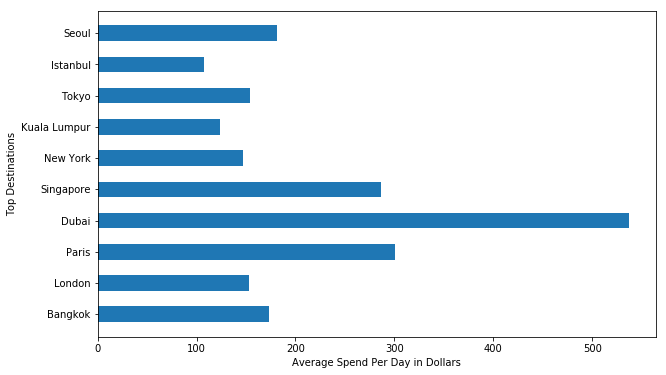

In [92]:
plt.figure(figsize=(10,6))
plt.barh(top_cities['City'], top_cities['AvgSpendPerDay'], height=0.5)

plt.ylabel('Top Destinations')
plt.xlabel('Average Spend Per Day in Dollars')
#plt.bar(top_cities['City'], top_cities['AvgSpendPerDay'], width=0.3, )

The highest expenditure is in Dubai, followed by Paris, Singapore, Seoul, Bangkok in descending order.

<h5> Graph 2: Bar Graph Showing Average Length Of Stay(expressed as number of nights) for each top city

Text(0.5, 0, 'Average Length Of Stay(Nights)')

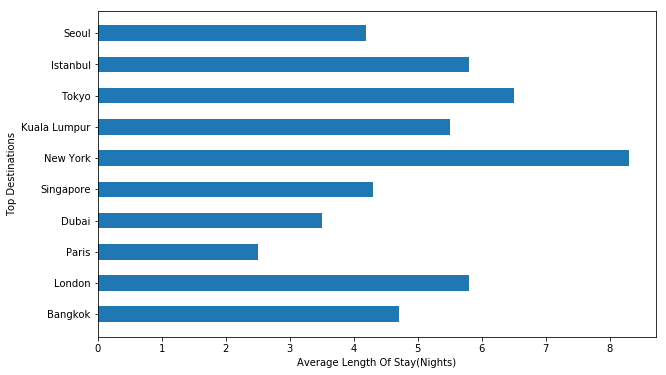

In [93]:
plt.figure(figsize=(10,6))
plt.barh(top_cities['City'], top_cities['AvgLengthOfStay'], height=0.5)

plt.ylabel('Top Destinations')
plt.xlabel('Average Length Of Stay(Nights)')

The longest was is in New York, followed by Tokyo, Istanbul, London, Bangkok in descending order.

<h5> Graph 3: Bar Graph Showing Total visitors for each top city in 2017

Text(0.5, 0, 'Number of Visitors')

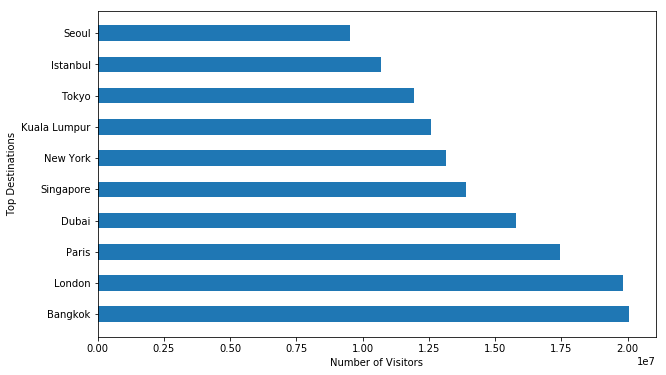

In [94]:

plt.figure(figsize=(10,6))
plt.barh(top_cities['City'], top_cities['VisitorCount'], height=0.5)

plt.ylabel('Top Destinations')
plt.xlabel('Number of Visitors')


The highest count of visitors was in Bangkok, followed by London, Paris, Dubai, Singapore in descending order.

<h5> Graph 4: Bar Graph Showing Growth forecast for each top city in 2017

Text(0.5, 0, 'Growth Forecast')

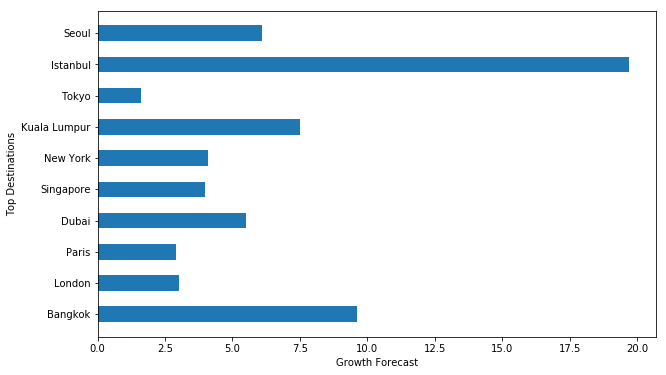

In [95]:

plt.figure(figsize=(10,6))
plt.barh(top_cities['City'], top_cities['GrowthForecast'], height=0.5)

plt.ylabel('Top Destinations')
plt.xlabel('Growth Forecast')

The highest growth was forecasted for Istanbul, followed by Bangkok, Kuala Lumpur, Seoul, Dubai in descending order.

<h4> Relationship Exploration

We can explore the relationships between the variables. It will be interesting to find how the other indicators affect visitor count and even vice versa.

<h5> Scatter plot 1: Relationship between Average spend per day and Length of stay

Pearson Correlation: Coefficient = -0.6301341589244333, p-value = 0.050840480068283116
SpearmanrResult(correlation=-0.8024353176576852, pvalue=0.005211461766706417)


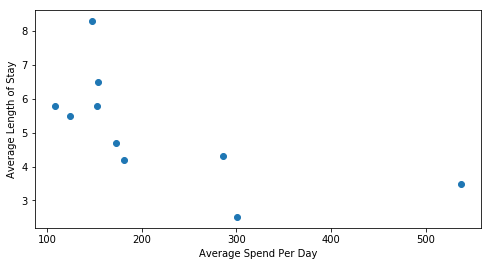

In [96]:
scatter_corr(top_cities['AvgSpendPerDay'], top_cities['AvgLengthOfStay'], 'Average Spend Per Day', 'Average Length of Stay', '')


Observation 1: There is a negative non-linear relationship between length of stay and the average spend per day. Visitors appear to stay long in cities where they spend less.

This is a reasonable observation.

<h5> Scatter plot 2: Relationship between Average Spend Per Day and Number of Visitors

Pearson Correlation: Coefficient = 0.24861067064924272, p-value = 0.48854899122182777
SpearmanrResult(correlation=0.3696969696969697, pvalue=0.2930500752928223)


Text(153.5, 17500000, 'Median Spend Per Day')

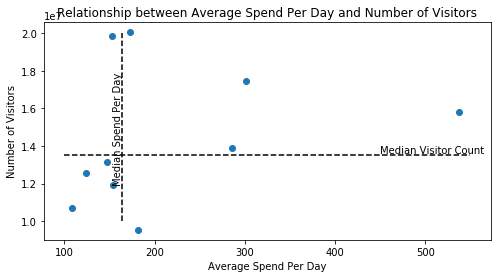

In [97]:
scatter_corr(top_cities['AvgSpendPerDay'], top_cities['VisitorCount'], 'Average Spend Per Day', 'Number of Visitors', \
           'Relationship between Average Spend Per Day and Number of Visitors')

plt.vlines(top_cities['AvgSpendPerDay'].median(), ymin=10000000, ymax=20000000, linestyles='dashed', label='median average spend per day')
plt.hlines(top_cities['VisitorCount'].median(), xmin=100, xmax=550, linestyles='dashed', label='median visitor count')
plt.annotate('Median Visitor Count', [450, top_cities['VisitorCount'].median()+100000])
plt.annotate('Median Spend Per Day', [top_cities['AvgSpendPerDay'].median()-10, 17500000], rotation=90)

There seems to be a non-linear relationship between the Number of visitors and the average spend per day. Notwithstanding, the average spend per day in cities ranking 2nd to 5th for number of visitors, are above the median.

<h5> Scatter plot 3: Relationship between Average Length of Stay and Number of Visitors

Pearson Correlation: Coefficient = -0.2706295034274189, p-value = 0.4494842595625964
SpearmanrResult(correlation=-0.24316221747202585, pvalue=0.49843371099777956)


Text(4.949999999999999, 17500000, 'Median Length Of Stay')

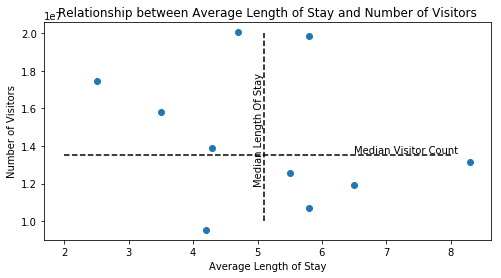

In [98]:
scatter_corr(top_cities['AvgLengthOfStay'], top_cities['VisitorCount'], 'Average Length of Stay', 'Number of Visitors', \
            'Relationship between Average Length of Stay and Number of Visitors')

plt.vlines(top_cities['AvgLengthOfStay'].median(), ymin=10000000, ymax=20000000, linestyles='dashed', label='median average spend per day')
plt.hlines(top_cities['VisitorCount'].median(), xmin=2, xmax=8, linestyles='dashed', label='median visitor count')
plt.annotate('Median Visitor Count', [6.5, top_cities['VisitorCount'].median()+100000])
plt.annotate('Median Length Of Stay', [top_cities['AvgLengthOfStay'].median()-0.15, 17500000], rotation=90)

<h5> Correlation Testing </h5>
<p>Using correlation to garner further insights about the relationships explored through the scatter plots. Three methods Pearson Correlation, Spearman Correlation, and the Kendall Tau Correlation. The Sperman correlation is particualrly useful given that some of the relationships are not linear. Pearson correlation do not do well for non-linear relationships </p>

Pearson Correlation

In [99]:
top_cities.corr(method='pearson')

,VisitorCount,GrowthForecast,AvgLengthOfStay,AvgSpendPerDay
VisitorCount,1.000000,-0.266352,-0.270630,0.248611
GrowthForecast,-0.266352,1.000000,0.061204,-0.286297
AvgLengthOfStay,-0.270630,0.061204,1.000000,-0.630134
AvgSpendPerDay,0.248611,-0.286297,-0.630134,1.000000


Spearman Rank Correlation


In [100]:
top_cities.corr(method='spearman')

,VisitorCount,GrowthForecast,AvgLengthOfStay,AvgSpendPerDay
VisitorCount,1.000000,-0.200000,-0.243162,0.369697
GrowthForecast,-0.200000,1.000000,-0.024316,-0.381818
AvgLengthOfStay,-0.243162,-0.024316,1.000000,-0.802435
AvgSpendPerDay,0.369697,-0.381818,-0.802435,1.000000


Kendall Tau Correlation

In [101]:
top_cities.corr(method='kendall')

,VisitorCount,GrowthForecast,AvgLengthOfStay,AvgSpendPerDay
VisitorCount,1.000000,-0.155556,-0.179787,0.288889
GrowthForecast,-0.155556,1.000000,0.044947,-0.333333
AvgLengthOfStay,-0.179787,0.044947,1.000000,-0.629253
AvgSpendPerDay,0.288889,-0.333333,-0.629253,1.000000


Interestingly, the highest correlation was recorded between average spend per day and average length of stay as was demonstrable in our scatter plots. Additionally, the spearman method produced the highest correlation at -0.80, proving non-linearity and monotonicity.

Rightfully, average spend per day and average length of day are negatively correlated, and this validates our first observation that visitors generally stay longer in cities where they spend less. 

<h3> d. Using Clustering to further explore data

Cluster mastercard index data

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


Text(5.1, 3.5, 'Elbow')

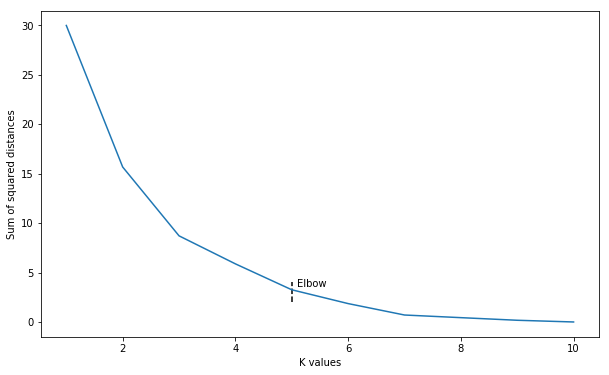

In [102]:
#cluster mastercard index data
mastercard_cluster = kmeans_cluster(top_cities.drop(['City', 'GrowthForecast'], 1), 11)

plt.vlines(5, ymin=2, ymax=4, linestyles='dashed')
plt.annotate('Elbow', [5.1,3.5])

Plotting K against Sum of Squared Distances, and using the Elbow method to determine the best K

In [103]:
#plot k and sums of squared distances to visualise elbow
#k_elbow(mastercard_cluster['ks'], mastercard_cluster['sumsqdis'])

#plt.vlines(5, ymin=2, ymax=4, linestyles='dashed')
#plt.annotate('Elbow', [5.1,3.5])

Getting labels from clustering with the best K and adding them to the cities dataframe

In [104]:
#Infering best k from plot above
best_k = 5

#obtaining the labels of clustering from the best K
kmeans_ex_labels = mastercard_cluster['clabels'][best_k-1]  #index of list starts from 0, but our K starts from 1
kmeans_ex_labels

array([2, 2, 0, 3, 0, 4, 1, 1, 1, 1])

In [105]:
top_cities_clust = top_cities.drop(['GrowthForecast'], 1)
top_cities_clust['ClusterLabels'] = kmeans_ex_labels #new dataframe with top cities dataframe and labels concatenated

<h5> Assessing clusters by Number of Visitors </h5>

In [106]:
top_cities_clust #[['City', 'VisitorCount', 'ClusterLabels']]

,City,VisitorCount,AvgLengthOfStay,AvgSpendPerDay,ClusterLabels
0,Bangkok,20050000,4.7,173,2
1,London,19830000,5.8,153,2
2,Paris,17440000,2.5,301,0
3,Dubai,15790000,3.5,537,3
4,Singapore,13910000,4.3,286,0
5,New York,13130000,8.3,147,4
6,Kuala Lumpur,12580000,5.5,124,1
7,Tokyo,11930000,6.5,154,1
8,Istanbul,10700000,5.8,108,1
9,Seoul,9540000,4.2,181,1


<h5>Assessing Clusters by the Average Length of Stay</h5>

In [107]:
top_cities_clust.sort_values(by=['AvgLengthOfStay'], ascending=False)
#[['City', 'AvgLengthOfStay', 'ClusterLabels']]

,City,VisitorCount,AvgLengthOfStay,AvgSpendPerDay,ClusterLabels
5,New York,13130000,8.3,147,4
7,Tokyo,11930000,6.5,154,1
1,London,19830000,5.8,153,2
8,Istanbul,10700000,5.8,108,1
6,Kuala Lumpur,12580000,5.5,124,1
0,Bangkok,20050000,4.7,173,2
4,Singapore,13910000,4.3,286,0
9,Seoul,9540000,4.2,181,1
3,Dubai,15790000,3.5,537,3
2,Paris,17440000,2.5,301,0


<h5>Assessing Clusters by the Average Spend Per Day</h5>

In [108]:
top_cities_clust.sort_values(by=['AvgSpendPerDay'], ascending=False)
#[['City', 'AvgSpendPerDay', 'ClusterLabels']]

,City,VisitorCount,AvgLengthOfStay,AvgSpendPerDay,ClusterLabels
3,Dubai,15790000,3.5,537,3
2,Paris,17440000,2.5,301,0
4,Singapore,13910000,4.3,286,0
9,Seoul,9540000,4.2,181,1
0,Bangkok,20050000,4.7,173,2
7,Tokyo,11930000,6.5,154,1
1,London,19830000,5.8,153,2
5,New York,13130000,8.3,147,4
6,Kuala Lumpur,12580000,5.5,124,1
8,Istanbul,10700000,5.8,108,1


<h5> Using Box Plots to visualize outliers and gain more insight into cluster characteristics

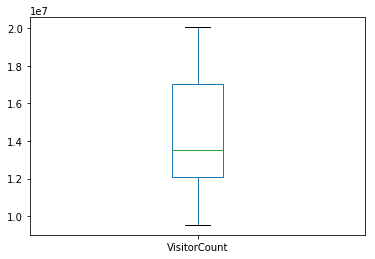

In [109]:
top_cities[['VisitorCount']].plot(kind='box')

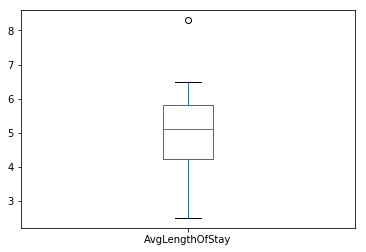

In [110]:
top_cities[['AvgLengthOfStay']].plot(kind='box')

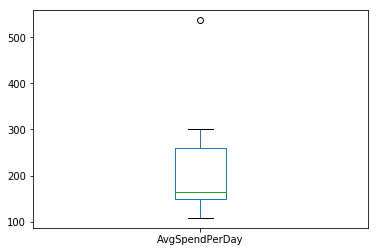

In [111]:
top_cities[['AvgSpendPerDay']].plot(kind='box')

<h5> Naming our Clusters </h5>

Given that there are outliers, it is more meaningful to use median and inter-quartile range to assess variability.
We will rate features as low, average, high based on the median and interquartile ranges.
Consequently, from our assessments, we can name our Clusters as:

<ul>
    <li>Most Visited, Moderate Spend Per Day, Average Length Of Stay</li>
    <li>Cities with Highest Spending, Average Visitor Count, Short Length of Stay</li>
    <li>Cities with Longest Stay, Average Visitor Count, Low Spend Per Day</li>
    <li>Cities with Above-Moderate Spend Per Day</li>
    <li>Least Visited, Average Length of Stay</li>
</ul>



In [112]:
cluster_dict = {}

<h5> Cluster Members</h5>

<p>Most Visited, Moderate Spend Per Day, Average Length Of Stay</p>

In [113]:
#top_cities_clust dataframe is already sorted by Visitor Count in descending order.
#The Cluster Label for the first row gives us the label for the most visited group

df_mv = top_cities_clust.sort_values(by=['VisitorCount'], ascending=False) \
    .loc[top_cities_clust['ClusterLabels']==top_cities_clust.iloc[0,4]]

cluster_dict[top_cities_clust.iloc[0,4]]= {'Description': 'Most Visited, Moderate Spend Per Day, Average Length Of Stay', \
                                          'Cities':tuple(df_mv['City'])}

df_mv

,City,VisitorCount,AvgLengthOfStay,AvgSpendPerDay,ClusterLabels
0,Bangkok,20050000,4.7,173,2
1,London,19830000,5.8,153,2


<p>Cities with Highest Spending, Short Length of Stay, Average Visitor Count</p>

In [114]:
by_spend = top_cities_clust.sort_values(by=['AvgSpendPerDay'], ascending=False)

df_hs = by_spend.loc[by_spend['ClusterLabels']==by_spend.iloc[0,4]]

cluster_dict[by_spend.iloc[0,4]]= {'Description':'Cities with Highest Spending, Short Length of Stay, Average Visitor Count', \
                                   'Cities':tuple(df_hs['City'])}

df_hs

,City,VisitorCount,AvgLengthOfStay,AvgSpendPerDay,ClusterLabels
3,Dubai,15790000,3.5,537,3


Cities with Longest Stay, Low Spend Per Day, Average Visitor Count

In [115]:
by_length = top_cities_clust.sort_values(by=['AvgLengthOfStay'], ascending=False)

df_ls = by_length.loc[by_length['ClusterLabels']==by_length.iloc[0,4]]

cluster_dict[by_length.iloc[0,4]]={'Description':'Cities with Longest Stay, Low Spend Per Day, Average Visitor Count', \
                                  'Cities':tuple(df_ls['City'])}

df_ls

,City,VisitorCount,AvgLengthOfStay,AvgSpendPerDay,ClusterLabels
5,New York,13130000,8.3,147,4


Cities with Above-Moderate Spend Per Day, but not the most Expensive

In [116]:

df_ams = by_spend.loc[by_spend['ClusterLabels']==by_spend.iloc[1,4]]

cluster_dict[by_spend.iloc[1,4]]={'Description':'Cities with Above-Moderate Spend Per Day, but not the most Expensive', \
                                 'Cities':tuple(df_ams['City'])}

df_ams

,City,VisitorCount,AvgLengthOfStay,AvgSpendPerDay,ClusterLabels
2,Paris,17440000,2.5,301,0
4,Singapore,13910000,4.3,286,0


Least Visited, Average Length of Stay

In [117]:

df_lv = top_cities_clust.loc[top_cities_clust['ClusterLabels']==top_cities_clust.iloc[9,4]]

cluster_dict[top_cities_clust.iloc[9,4]]={'Description':'Least Visited, Average Length of Stay', \
                                         'Cities':tuple(df_lv['City'])}

df_lv

,City,VisitorCount,AvgLengthOfStay,AvgSpendPerDay,ClusterLabels
6,Kuala Lumpur,12580000,5.5,124,1
7,Tokyo,11930000,6.5,154,1
8,Istanbul,10700000,5.8,108,1
9,Seoul,9540000,4.2,181,1


<h3>e. Observations and Inferences from Exploratory Analysis</h4>

<ul>
    <li>The most visited cities demonstrate a balance in spending and length of stay</li>
    <li>It is likely most people visiting Dubai do so for business. </li>
    <li>It is likely that New York is visited most by people on vacation<li>
    <li>Majority of top visited cities are in Asia</li>
    <li>People generally stay longer in cities they spend less</li>
    <li>More people visit cities where spending is average to high</li>
    <li>Length of Stay and Number of visitors for cities appear not to depend only on Spending</li>
</ul>



<h3> f. Ushering into the Next Stage</h3>

There is reason to believe that infrastructure is important for tourism. People travel for business or leisure. If they want to shop, there must be diverse shopping opportunities to be atrractive to visitors. For people on vacation or business, the hospitality facilities, and memorable locations like museums etc are important.
On the premise of the third point from our observations, I leverage foursquare location data to investigate distribution, diversity and availability of facilities of interest to travellers in the top ten cities.

<h2> 3. INSIGHTS FROM LOCATION DATA FROM TOP MOST VISITED CITIES 2017

In [118]:
!pip install geopy

<h3> a. Geolocation Data Acquisition and Map Visualization for top 10 cities </h3>

<p>Obtaining Latitudes and Longitudes using get_lonlats function

In [119]:
geodata1 = get_lonlats(top_cities['City'])
geodata1

,City,Latitude,Longitude
0,Bangkok,13.753893,100.816080
1,London,51.507322,-0.127647
2,Paris,48.856610,2.351499
3,Dubai,25.075010,55.188761
4,Singapore,1.340853,103.878447
5,New York,40.730862,-73.987156
6,Kuala Lumpur,3.151664,101.694303
7,Tokyo,35.682839,139.759455
8,Istanbul,41.009633,28.965165
9,Seoul,37.566679,126.978291


In [120]:
map_df1 = geodata1
map_df1['ClusterLabels'] = top_cities_clust['ClusterLabels']

#create folium map using map_folium function
# function guide:   map_folium(dataframe, loc = [-8.7832, 34.5085], clus_dict = cluster_dict)
map1 = map_folium(map_df1, clus_dict=cluster_dict, circle_radius=6)
print(map1['mapkey'])
map1['map']

[ MAP KEY ]
CYAN: Most Visited, Moderate Spend Per Day, Average Length Of Stay
BLUE: Cities with Longest Stay, Low Spend Per Day, Average Visitor Count
YELLOW: Cities with Highest Spending, Short Length of Stay, Average Visitor Count
GREEN: Least Visited, Average Length of Stay
RED: Cities with Above-Moderate Spend Per Day, but not the most Expensive



<h4>Filtering out foursquare categories that are linked to tourism. This was manually compiled.

In [121]:
category_dict = {'Arts & Entertainment':'4d4b7104d754a06370d81259', 'Food':'4d4b7105d754a06374d81259', 
 'Nightlife & Spot':'4d4b7105d754a06376d81259', 'Outdoors & Recreation':'4d4b7105d754a06377d81259', 
 'Shop & Service':'4d4b7105d754a06378d81259','Hotel':'4bf58dd8d48988d1fa931735',
 'Transportation Service':'54541b70498ea6ccd0204bff', 'Travel Lounge':'4f04b25d2fb6e1c99f3db0c0',
'Rental Car Location':'4bf58dd8d48988d1ef941735','Rest Area':'4d954b16a243a5684b65b473',
 'Food & Drink Shop':'4bf58dd8d48988d1f9941735', 'ATM':'52f2ab2ebcbc57f1066b8b56', 
 'Adult Boutique':'5267e446e4b0ec79466e48c4', 'Antique Shop':'4bf58dd8d48988d116951735',
 'Arts & Crafts Store':'4bf58dd8d48988d127951735','Bank':'4bf58dd8d48988d10a951735',
 'Business Service':'5453de49498eade8af355881','Candy Store':'4bf58dd8d48988d117951735',
 'Chocolate Shop':'52f2ab2ebcbc57f1066b8b31','Clothing Store':'4bf58dd8d48988d103951735',
 'Convenience Store':'4d954b0ea243a5684a65b473','Cosmetics Shop':'4bf58dd8d48988d10c951735',
 'Costume Shop':'52f2ab2ebcbc57f1066b8b17', 'Discount Store':'52dea92d3cf9994f4e043dbb',
 'Electronics Store':'4bf58dd8d48988d122951735','Entertainment Service':'56aa371be4b08b9a8d573554',
 'Event Service':'5454152e498ef71e2b9132c6','Fabric Shop':'52f2ab2ebcbc57f1066b8b26',
 'Film Studio':'56aa371be4b08b9a8d573523','Gaming Cafe':'4bf58dd8d48988d18d941735',
 'Gift Shop':'4bf58dd8d48988d128951735', 'Massage Studio':'52f2ab2ebcbc57f1066b8b3c',
 'Outdoor Supply Store':'52f2ab2ebcbc57f1066b8b22','Outlet Mall':'5744ccdfe4b0c0459246b4df',
 'Outlet Store':'52f2ab2ebcbc57f1066b8b35','Pop-Up Shop':'52f2ab2ebcbc57f1066b8b3d',
 'Shopping Mall':'4bf58dd8d48988d1fd941735','Shopping Plaza':'5744ccdfe4b0c0459246b4dc',
 'Smoothie Shop':'52f2ab2ebcbc57f1066b8b41','Souvenir Shop':'52f2ab2ebcbc57f1066b8b1b',
 'Spa':'4bf58dd8d48988d1ed941735','Thrift / Vintage Store':'4bf58dd8d48988d101951735',
 'Travel & Transport':'4d4b7105d754a06379d81259'}

In [122]:
cat_codes = ''

for key in category_dict:
    if cat_codes=='':
        cat_codes=category_dict[key]
    else:   
        cat_codes += ',{}'.format(category_dict[key])
    
cat_codes

'4d4b7104d754a06370d81259,4d4b7105d754a06374d81259,4d4b7105d754a06376d81259,4d4b7105d754a06377d81259,4d4b7105d754a06378d81259,4bf58dd8d48988d1fa931735,54541b70498ea6ccd0204bff,4f04b25d2fb6e1c99f3db0c0,4bf58dd8d48988d1ef941735,4d954b16a243a5684b65b473,4bf58dd8d48988d1f9941735,52f2ab2ebcbc57f1066b8b56,5267e446e4b0ec79466e48c4,4bf58dd8d48988d116951735,4bf58dd8d48988d127951735,4bf58dd8d48988d10a951735,5453de49498eade8af355881,4bf58dd8d48988d117951735,52f2ab2ebcbc57f1066b8b31,4bf58dd8d48988d103951735,4d954b0ea243a5684a65b473,4bf58dd8d48988d10c951735,52f2ab2ebcbc57f1066b8b17,52dea92d3cf9994f4e043dbb,4bf58dd8d48988d122951735,56aa371be4b08b9a8d573554,5454152e498ef71e2b9132c6,52f2ab2ebcbc57f1066b8b26,56aa371be4b08b9a8d573523,4bf58dd8d48988d18d941735,4bf58dd8d48988d128951735,52f2ab2ebcbc57f1066b8b3c,52f2ab2ebcbc57f1066b8b22,5744ccdfe4b0c0459246b4df,52f2ab2ebcbc57f1066b8b35,52f2ab2ebcbc57f1066b8b3d,4bf58dd8d48988d1fd941735,5744ccdfe4b0c0459246b4dc,52f2ab2ebcbc57f1066b8b41,52f2ab2ebcbc57f1066b8b1b

<h4>Using filtered venue categories to query tourism related venues and services

In [123]:
top_cities_fsq=nearby_services(geo_data=geodata1, CATEGORYID=cat_codes)

top_cities_fsq['venues'][0:10]

[['Bangkok',
  13.7538929,
  100.8160803,
  2,
  'ARL Latkrabang (A2) (ARL ลาดกระบัง)',
  13.727637765326877,
  100.74840786863355,
  'Train Station',
  '4bf58dd8d48988d129951735'],
 ['Bangkok',
  13.7538929,
  100.8160803,
  2,
  'KMITL Walking Street (สถานีคนเดิน พระจอมเกล้าฯลาดกระบัง (KMITL Walking Street))',
  13.728510044750138,
  100.77324827367164,
  'Pedestrian Plaza',
  '52e81612bcbc57f1066b7a25'],
 ['Bangkok',
  13.7538929,
  100.8160803,
  2,
  '7-Eleven (เซเว่นอีเลฟเว่น)',
  13.721814209007494,
  100.7837718740407,
  'Convenience Store',
  '4d954b0ea243a5684a65b473'],
 ['Bangkok',
  13.7538929,
  100.8160803,
  2,
  'OPC - Cabin Crew Lounge',
  13.710236711801459,
  100.75804146514126,
  'Travel Lounge',
  '4f04b25d2fb6e1c99f3db0c0'],
 ['Bangkok',
  13.7538929,
  100.8160803,
  2,
  'โรงอาหารตึก A',
  13.72689281698952,
  100.77572290441331,
  'Thai Restaurant',
  '4bf58dd8d48988d149941735'],
 ['Bangkok',
  13.7538929,
  100.8160803,
  2,
  'ปตท. (PTT) (ปตท.)',
  13.7491875

In [124]:
csv_df = pd.DataFrame(top_cities_fsq['venues'])
csv_df.to_csv('VenuesCities2.csv')

In [125]:
fsq_cities_df=pd.DataFrame(top_cities_fsq['venues'])
print(len(top_cities_fsq['venues']))
fsq_cities_df.head()

500


,0,1,2,3,4,5,6,7,8
0,Bangkok,13.753893,100.81608,2,ARL Latkrabang (A2) (ARL ลาดกระบัง),13.727638,100.748408,Train Station,4bf58dd8d48988d129951735
1,Bangkok,13.753893,100.81608,2,KMITL Walking Street (สถานีคนเดิน พระจอมเกล้าฯ...,13.728510,100.773248,Pedestrian Plaza,52e81612bcbc57f1066b7a25
2,Bangkok,13.753893,100.81608,2,7-Eleven (เซเว่นอีเลฟเว่น),13.721814,100.783772,Convenience Store,4d954b0ea243a5684a65b473
3,Bangkok,13.753893,100.81608,2,OPC - Cabin Crew Lounge,13.710237,100.758041,Travel Lounge,4f04b25d2fb6e1c99f3db0c0
4,Bangkok,13.753893,100.81608,2,โรงอาหารตึก A,13.726893,100.775723,Thai Restaurant,4bf58dd8d48988d149941735


<h4> Categorising venue categories into hospitality sectors

Changing 'Café' to Cafee for easy replacement. 'é' might be a challenge

In [126]:
fsq_cities_df.loc[fsq_cities_df[7] == 'Café', 7] = 'Cafee'
fsq_cities_df.loc[fsq_cities_df[7] == 'Cafee']

,0,1,2,3,4,5,6,7,8
20,Bangkok,13.753893,100.816080,2,Brown Beary Café (บราวน์แบร์รี่คาเฟ่),13.731069,100.781748,Cafee,4bf58dd8d48988d16d941735
36,Bangkok,13.753893,100.816080,2,Timber Cafe',13.727143,100.765975,Cafee,4bf58dd8d48988d16d941735
42,Bangkok,13.753893,100.816080,2,ป้านาง คาเฟ่,13.725339,100.773728,Cafee,4bf58dd8d48988d16d941735
62,London,51.507322,-0.127647,2,EL&N,51.496728,-0.168652,Cafee,4bf58dd8d48988d16d941735
64,London,51.507322,-0.127647,2,EL&N,51.514300,-0.151598,Cafee,4bf58dd8d48988d16d941735
69,London,51.507322,-0.127647,2,L'ETO Caffè,51.496661,-0.168792,Cafee,4bf58dd8d48988d16d941735
85,London,51.507322,-0.127647,2,EL&N,51.499647,-0.162241,Cafee,4bf58dd8d48988d16d941735
99,London,51.507322,-0.127647,2,The Coffee Bar,51.499171,-0.162803,Cafee,4bf58dd8d48988d16d941735
131,Paris,48.856610,2.351499,0,86 Champs (L'Occitane x Pierre Hermé),48.871514,2.303698,Cafee,4bf58dd8d48988d16d941735
157,Dubai,25.075010,55.188761,3,Yalseh,25.076143,55.130304,Cafee,4bf58dd8d48988d16d941735


Replacing venue categories with Sectors

In [127]:
#open created category - sector guide csv
#based on foursquare categories

#open csv
with open('top_categories2.csv', 'r') as tc:
    topc = tc.readlines()
    
topc.pop(0) #delete headers

#create key-value pairs for venue categories and corresponding sectors
topc_dict = {category.strip():sector.strip() for category, sector in [row.split(',') for row in topc]}

#get corresponding sectors of venue categories in foursquare dataframe into list to be appended to table
sector_list = []
for item in fsq_cities_df[7]:
    sector_list.append(topc_dict[item])
    
print(sector_list[0:30])

['Transport', 'Recreation', 'Shopping', 'Transport', 'Food', 'Not Hospitality', 'Shopping', 'Not Hospitality', 'Food', 'Shopping', 'Recreation', 'Food', 'Recreation', 'Shopping', 'Shopping', 'Not Hospitality', 'Food', 'Shopping', 'Shopping', 'Food', 'Food', 'Food', 'Shopping', 'Food', 'Food', 'Not Hospitality', 'Food', 'Shopping', 'Shopping', 'Food']


<h4> Adding Sector List

In [128]:
fsq_cities_df[len(fsq_cities_df.columns)] = sector_list
fsq_cities_df.head()

,0,1,2,3,4,5,6,7,8,9
0,Bangkok,13.753893,100.81608,2,ARL Latkrabang (A2) (ARL ลาดกระบัง),13.727638,100.748408,Train Station,4bf58dd8d48988d129951735,Transport
1,Bangkok,13.753893,100.81608,2,KMITL Walking Street (สถานีคนเดิน พระจอมเกล้าฯ...,13.728510,100.773248,Pedestrian Plaza,52e81612bcbc57f1066b7a25,Recreation
2,Bangkok,13.753893,100.81608,2,7-Eleven (เซเว่นอีเลฟเว่น),13.721814,100.783772,Convenience Store,4d954b0ea243a5684a65b473,Shopping
3,Bangkok,13.753893,100.81608,2,OPC - Cabin Crew Lounge,13.710237,100.758041,Travel Lounge,4f04b25d2fb6e1c99f3db0c0,Transport
4,Bangkok,13.753893,100.81608,2,โรงอาหารตึก A,13.726893,100.775723,Thai Restaurant,4bf58dd8d48988d149941735,Food


<h4> Spreading out Sectors</h4>

Applying one-hot and grouping by the cities' means for each sector

In [129]:
fsq_cities_sectordf = pd.get_dummies(fsq_cities_df[9], prefix='', prefix_sep='')

fsq_cities_sectordf['City'] = fsq_cities_df[0]

#fsq_cities_df2.head()

fsq_cities_sec = fsq_cities_sectordf.groupby('City').mean().reset_index()
#fsq_cities_clust = fsq_cities_clust.drop(['Neighborhood', 'County', 'Road', 'State', 'Building', 'Country', 'Town', 'Gas Station'], 1)
fsq_cities_sec

,City,Food,Lodging,Not Hospitality,Recreation,Shopping,Transport
0,Bangkok,0.42,0.00,0.14,0.08,0.30,0.06
1,Dubai,0.28,0.10,0.10,0.26,0.18,0.08
2,Istanbul,0.14,0.00,0.30,0.40,0.12,0.04
3,Kuala Lumpur,0.22,0.00,0.10,0.12,0.30,0.26
4,London,0.18,0.04,0.08,0.26,0.12,0.32
5,New York,0.00,0.00,0.00,0.32,0.12,0.56
6,Paris,0.10,0.00,0.14,0.48,0.12,0.16
7,Seoul,0.00,0.00,0.08,0.24,0.16,0.52
8,Singapore,0.08,0.04,0.08,0.14,0.32,0.34
9,Tokyo,0.00,0.00,0.04,0.08,0.02,0.86


<h3>Clustering</h3>
<p>Clustering cities based on their hospitality sectors</p>

<h4>Function to prepare dataframe for cluster</h4>

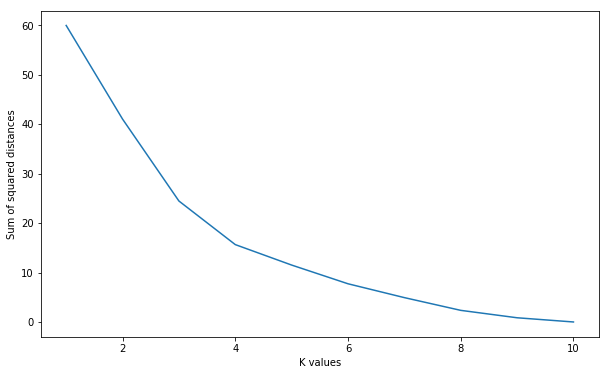

In [130]:
#cluster sector dataframe using Kmeans function in first section
#kmeans function guide:  kmeans_cluster(dataframe, max k)
seccluster = kmeans_cluster(fsq_cities_sec.drop(['City'], 1), 11)  

#visualize elbow
#plt.vlines(6, ymin=8, ymax=14, linestyles='dashed')
#plt.annotate('Elbow', [6.1,3.5])

In [131]:
best_k = 4  #choose best k

#get labels from best K
tsclust_labels = seccluster['clabels'][best_k-1] 
tsclust_labels

array([0, 1, 3, 0, 1, 2, 3, 2, 0, 2])

In [132]:
#add cluster labels to sector dataframe
fsq_cities_sec['ClusterLabels']=tsclust_labels

fsq_cities_sec


,City,Food,Lodging,Not Hospitality,Recreation,Shopping,Transport,ClusterLabels
0,Bangkok,0.42,0.00,0.14,0.08,0.30,0.06,0
1,Dubai,0.28,0.10,0.10,0.26,0.18,0.08,1
2,Istanbul,0.14,0.00,0.30,0.40,0.12,0.04,3
3,Kuala Lumpur,0.22,0.00,0.10,0.12,0.30,0.26,0
4,London,0.18,0.04,0.08,0.26,0.12,0.32,1
5,New York,0.00,0.00,0.00,0.32,0.12,0.56,2
6,Paris,0.10,0.00,0.14,0.48,0.12,0.16,3
7,Seoul,0.00,0.00,0.08,0.24,0.16,0.52,2
8,Singapore,0.08,0.04,0.08,0.14,0.32,0.34,0
9,Tokyo,0.00,0.00,0.04,0.08,0.02,0.86,2


In [133]:
MCI_Rank = []

for city in fsq_cities_sec['City']:
    MCI_Rank.append(original_ranking.index(city)+1)
    
fsq_cities_sec['MCI_Rank'] = MCI_Rank 



In [134]:
fsq_cities_sec = fsq_cities_sec.sort_values(by=['MCI_Rank']).reset_index()
fsq_cities_sec

,index,City,Food,Lodging,Not Hospitality,Recreation,Shopping,Transport,ClusterLabels,MCI_Rank
0,0,Bangkok,0.42,0.00,0.14,0.08,0.30,0.06,0,1
1,4,London,0.18,0.04,0.08,0.26,0.12,0.32,1,2
2,6,Paris,0.10,0.00,0.14,0.48,0.12,0.16,3,3
3,1,Dubai,0.28,0.10,0.10,0.26,0.18,0.08,1,4
4,8,Singapore,0.08,0.04,0.08,0.14,0.32,0.34,0,5
5,5,New York,0.00,0.00,0.00,0.32,0.12,0.56,2,6
6,3,Kuala Lumpur,0.22,0.00,0.10,0.12,0.30,0.26,0,7
7,9,Tokyo,0.00,0.00,0.04,0.08,0.02,0.86,2,8
8,2,Istanbul,0.14,0.00,0.30,0.40,0.12,0.04,3,9
9,7,Seoul,0.00,0.00,0.08,0.24,0.16,0.52,2,10


<h4> Setting up a dataframe to assess relationships between sectors and Mastercard Index indicators</h4>

In [135]:
#deriving dataframe for correlation from sector dataframe
fsq_cities_seccorr = fsq_cities_sec.drop(['index','MCI_Rank'], 1)

#adding mastercard index indicators to correlation dataframe
fsq_cities_seccorr['GrowthForecast'] = top_cities['GrowthForecast']
fsq_cities_seccorr['VisitorCount']= top_cities['VisitorCount']
fsq_cities_seccorr['AvgSpendPerDay']= top_cities['AvgSpendPerDay']
fsq_cities_seccorr['AvgLengthOfStay']= top_cities['AvgLengthOfStay']

fsq_cities_seccorr

,City,Food,Lodging,Not Hospitality,Recreation,Shopping,Transport,ClusterLabels,GrowthForecast,VisitorCount,AvgSpendPerDay,AvgLengthOfStay
0,Bangkok,0.42,0.00,0.14,0.08,0.30,0.06,0,9.6,20050000,173,4.7
1,London,0.18,0.04,0.08,0.26,0.12,0.32,1,3.0,19830000,153,5.8
2,Paris,0.10,0.00,0.14,0.48,0.12,0.16,3,2.9,17440000,301,2.5
3,Dubai,0.28,0.10,0.10,0.26,0.18,0.08,1,5.5,15790000,537,3.5
4,Singapore,0.08,0.04,0.08,0.14,0.32,0.34,0,4.0,13910000,286,4.3
5,New York,0.00,0.00,0.00,0.32,0.12,0.56,2,4.1,13130000,147,8.3
6,Kuala Lumpur,0.22,0.00,0.10,0.12,0.30,0.26,0,7.5,12580000,124,5.5
7,Tokyo,0.00,0.00,0.04,0.08,0.02,0.86,2,1.6,11930000,154,6.5
8,Istanbul,0.14,0.00,0.30,0.40,0.12,0.04,3,19.7,10700000,108,5.8
9,Seoul,0.00,0.00,0.08,0.24,0.16,0.52,2,6.1,9540000,181,4.2


<h4> Deriving Pearson Correlation statistics </h4>

To assess linear relationships

In [136]:
fsq_cities_seccorr.corr(method='pearson')

,Food,Lodging,Not Hospitality,Recreation,Shopping,Transport,ClusterLabels,GrowthForecast,VisitorCount,AvgSpendPerDay,AvgLengthOfStay
Food,1.000000,0.312077,0.354425,-0.256984,0.557925,-0.747748,-0.556579,0.315073,0.652116,0.241321,-0.316207
Lodging,0.312077,1.000000,-0.111852,-0.020661,0.131929,-0.294662,-0.318697,-0.205237,0.291765,0.833254,-0.337232
Not Hospitality,0.354425,-0.111852,1.000000,0.393842,0.070510,-0.705358,0.302808,0.871161,-0.047014,-0.093959,-0.308268
Recreation,-0.256984,-0.020661,0.393842,1.000000,-0.429392,-0.337282,0.772373,0.215792,-0.014991,0.149161,-0.200208
Shopping,0.557925,0.131929,0.070510,-0.429392,1.000000,-0.485350,-0.805039,0.151268,0.206654,0.117023,-0.298357
Transport,-0.747748,-0.294662,-0.705358,-0.337282,-0.485350,1.000000,0.143984,-0.572308,-0.433620,-0.324106,0.517687
ClusterLabels,-0.556579,-0.318697,0.302808,0.772373,-0.805039,0.143984,1.000000,0.186061,-0.351510,-0.108619,0.038046
GrowthForecast,0.315073,-0.205237,0.871161,0.215792,0.151268,-0.572308,0.186061,1.000000,-0.266352,-0.286297,0.061204
VisitorCount,0.652116,0.291765,-0.047014,-0.014991,0.206654,-0.433620,-0.351510,-0.266352,1.000000,0.248611,-0.270630
AvgSpendPerDay,0.241321,0.833254,-0.093959,0.149161,0.117023,-0.324106,-0.108619,-0.286297,0.248611,1.000000,-0.630134


In [137]:
fsq_cities_seccorr.corr(method='spearman')

,Food,Lodging,Not Hospitality,Recreation,Shopping,Transport,ClusterLabels,GrowthForecast,VisitorCount,AvgSpendPerDay,AvgLengthOfStay
Food,1.000000,0.318511,0.668763,-0.129632,0.476308,-0.803741,-0.506420,0.472428,0.607408,0.055219,-0.295397
Lodging,0.318511,1.000000,-0.114467,0.056527,0.314038,-0.089893,-0.405772,-0.224733,0.404520,0.471940,-0.281772
Not Hospitality,0.668763,-0.114467,1.000000,0.248466,0.239647,-0.944606,0.095549,0.555651,0.209913,0.024696,-0.476837
Recreation,-0.129632,0.056527,0.248466,1.000000,-0.378702,-0.268298,0.692043,-0.048781,0.000000,0.012195,-0.162080
Shopping,0.476308,0.314038,0.239647,-0.378702,1.000000,-0.301120,-0.792884,0.464226,0.232113,0.276026,-0.465639
Transport,-0.803741,-0.089893,-0.944606,-0.268298,-0.301120,1.000000,0.031265,-0.624242,-0.345455,-0.006061,0.389060
ClusterLabels,-0.506420,-0.405772,0.095549,0.692043,-0.792884,0.031265,1.000000,-0.187592,-0.406449,-0.093796,0.062721
GrowthForecast,0.472428,-0.224733,0.555651,-0.048781,0.464226,-0.624242,-0.187592,1.000000,-0.200000,-0.381818,-0.024316
VisitorCount,0.607408,0.404520,0.209913,0.000000,0.232113,-0.345455,-0.406449,-0.200000,1.000000,0.369697,-0.243162
AvgSpendPerDay,0.055219,0.471940,0.024696,0.012195,0.276026,-0.006061,-0.093796,-0.381818,0.369697,1.000000,-0.802435


Pearson Correlation: Coefficient = 0.652116425240747, p-value = 0.041013188266022065
SpearmanrResult(correlation=0.6074076879484503, pvalue=0.06252817596740043)


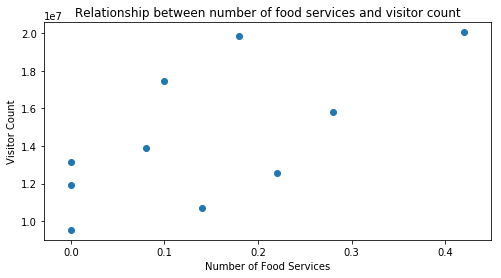

In [138]:
scatter_corr(fsq_cities_seccorr['Food'], fsq_cities_seccorr['VisitorCount'], \
        'Number of Food Services', 'Visitor Count', 'Relationship between number of food services and visitor count')

Pearson Correlation: Coefficient = 0.8332544788304987, p-value = 0.002751310756238751
SpearmanrResult(correlation=0.4719399037242695, pvalue=0.16846970441862522)


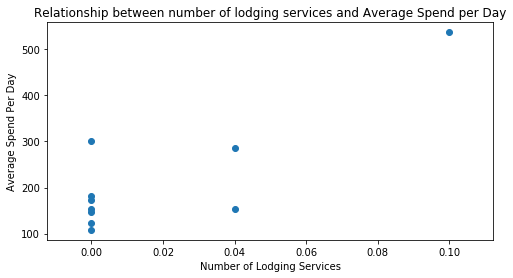

In [139]:
scatter_corr(fsq_cities_seccorr['Lodging'], fsq_cities_seccorr['AvgSpendPerDay'], \
        'Number of Lodging Services', 'Average Spend Per Day', 'Relationship between number of lodging services and Average Spend per Day')

Pearson Correlation: Coefficient = 0.5176869812986228, p-value = 0.12536575684326665
SpearmanrResult(correlation=0.38905954795524134, pvalue=0.2664779212005221)


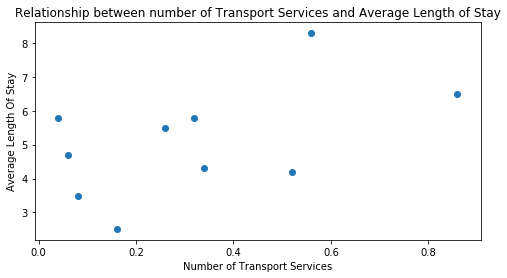

In [140]:
scatter_corr(fsq_cities_seccorr['Transport'], fsq_cities_seccorr['AvgLengthOfStay'], \
        'Number of Transport Services', 'Average Length Of Stay', 'Relationship between number of Transport Services and Average Length of Stay')

Pearson Correlation: Coefficient = -0.5723078222569198, p-value = 0.08382743042785956
SpearmanrResult(correlation=-0.6242424242424242, pvalue=0.053717767217167395)


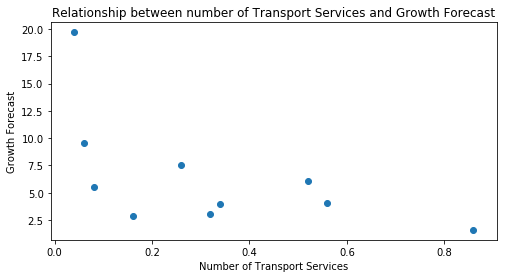

In [141]:
scatter_corr(fsq_cities_seccorr['Transport'], fsq_cities_seccorr['GrowthForecast'], \
        'Number of Transport Services', 'Growth Forecast', 'Relationship between number of Transport Services and Growth Forecast')

Pearson Correlation: Coefficient = 0.3150727585741259, p-value = 0.3752190342695772
SpearmanrResult(correlation=0.4724282017376836, pvalue=0.1679685554116793)


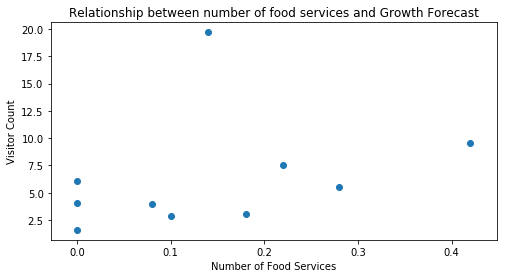

In [142]:
scatter_corr(fsq_cities_seccorr['Food'], fsq_cities_seccorr['GrowthForecast'], \
        'Number of Food Services', 'Visitor Count', 'Relationship between number of food services and Growth Forecast')

Pearson Correlation: Coefficient = 0.15126792962300104, p-value = 0.6765696353232513
SpearmanrResult(correlation=0.46422592173940186, pvalue=0.1765051741746287)


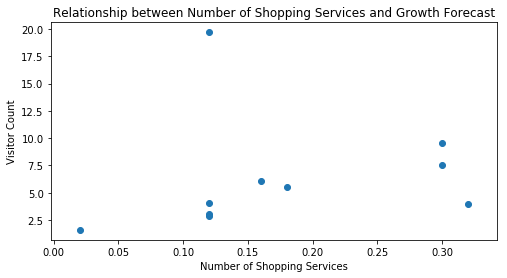

In [143]:
scatter_corr(fsq_cities_seccorr['Shopping'], fsq_cities_seccorr['GrowthForecast'], \
        'Number of Shopping Services', 'Visitor Count', 'Relationship between Number of Shopping Services and Growth Forecast')

              Food  Lodging  Transport  Shopping  Recreation  ClusterLabels
City                                                                       
Bangkok       0.42     0.00       0.06      0.30        0.08              0
Singapore     0.08     0.04       0.34      0.32        0.14              0
Kuala Lumpur  0.22     0.00       0.26      0.30        0.12              0
London        0.18     0.04       0.32      0.12        0.26              1
Dubai         0.28     0.10       0.08      0.18        0.26              1
New York      0.00     0.00       0.56      0.12        0.32              2
Tokyo         0.00     0.00       0.86      0.02        0.08              2
Seoul         0.00     0.00       0.52      0.16        0.24              2
Paris         0.10     0.00       0.16      0.12        0.48              3
Istanbul      0.14     0.00       0.04      0.12        0.40              3


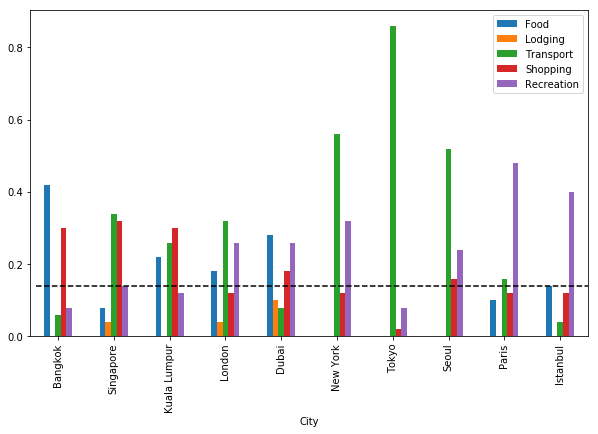

In [144]:

final_cities = fsq_cities_seccorr[['City', 'Food', 'Lodging', 'Transport', 'Shopping', 'Recreation', 'ClusterLabels']].set_index(['City']) #.plot(kind='bar', figsize=(10,6))
final_cities = final_cities.sort_values(by=['ClusterLabels'], ascending=True)
print(final_cities)
final_cities.drop(['ClusterLabels'], 1).plot(kind='bar', figsize=(10,6))

plt.hlines(0.14, -0.4, 9.5, linestyle='dashed')
#plt.hlines(0.5, 1.5, 5.4)
#plt.hlines(0.3, 5.5, 6.4)
#plt.hlines(0.88, 6.5, 9.4)
#plt.annotate('Recreation', [0,0.62])
#plt.annotate('Shopping, Food/Transport', [1.5,0.52])
#plt.annotate('Balanced', [5.5, 0.32])
#plt.annotate('Transport, Recreation', [6.5, 0.89])


<H2>IDENTIFYING CLUSTERS AND TRENDS

<h3> Balanced, market diversity

In [145]:
df_lodge = final_cities.sort_values(by=['Lodging'], ascending=False)
df_lodge.loc[df_lodge['ClusterLabels']==df_lodge.iloc[0,5]]


,Food,Lodging,Transport,Shopping,Recreation,ClusterLabels
City,,,,,,
Dubai,0.28,0.10,0.08,0.18,0.26,1
London,0.18,0.04,0.32,0.12,0.26,1


<h3> Transport and Recreation

In [151]:
df_tt = final_cities.sort_values(by=['Transport'], ascending=False)
df_tt.loc[df_tt['ClusterLabels']==df_tt.iloc[0,5]]


,Food,Lodging,Transport,Shopping,Recreation,ClusterLabels
City,,,,,,
Tokyo,0.0,0.0,0.86,0.02,0.08,2
New York,0.0,0.0,0.56,0.12,0.32,2
Seoul,0.0,0.0,0.52,0.16,0.24,2


<h3> Shopping, Food/Transport

In [147]:
df_shop = final_cities.sort_values(by=['Shopping'], ascending=False)
df_shop.loc[df_shop['ClusterLabels']==df_shop.iloc[0,5]]


,Food,Lodging,Transport,Shopping,Recreation,ClusterLabels
City,,,,,,
Singapore,0.08,0.04,0.34,0.32,0.14,0
Bangkok,0.42,0.00,0.06,0.30,0.08,0
Kuala Lumpur,0.22,0.00,0.26,0.30,0.12,0


<h3> Recreation and Shopping

In [148]:
df_rec = final_cities.sort_values(by=['Recreation'], ascending=False)
df_rec.loc[df_rec['ClusterLabels']==df_rec.iloc[0,5]]


,Food,Lodging,Transport,Shopping,Recreation,ClusterLabels
City,,,,,,
Paris,0.10,0.0,0.16,0.12,0.48,3
Istanbul,0.14,0.0,0.04,0.12,0.40,3
